# Other types of agents

In [1]:
from atom import *
from data_processing import *
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stats
plt.rcParams['figure.figsize'] = (15,10)

## ZIT with different ask and bid probabilities

You can create ZITs with probabilities of sending asks / sending bids different from $\dfrac{1}{2}$. One can also choose the interval in which they draw the price (initially $[\![1000,9999]\!]$) and the quantity (initially $[\![1,9]\!]$). To do this, we will use the parameters p_min, p_max, q_min, q_max, pb_ask and pb_bid. If pb_ask + pb_bid < 1, then the ZIT will not send any order with probability 1- (pb_ask + pb_bid).


In [2]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file, trace=['wealth'])
t1 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.5, pb_bid=0.5)
t2 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.1, pb_bid=0.1)
m.add_trader(t1)
m.add_trader(t2)
for i in range(200):
    m.run_once()
m.print_state()
file.close()

print(t1.get_infos(m))
print(t2.get_infos(m))

ZIT 1:
Cash: -273
Apple: -8
Wealth: -4849

ZIT 2:
Cash: 273
Apple: 8
Wealth: 4849



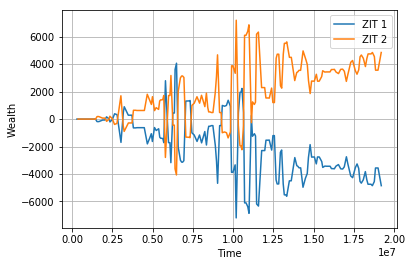

In [3]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

## Another type of ZIT...

We will create a ZIT type with two parameters `delta` and `pb_cancel`. This ZIT will send with probability pb_cancel a `CancelMyOrders` order, which cancels all its orders in a given order book, and with probability 1 - pb_cancel, it will send a `LimitOrder` for which it will choose the price uniformly between $p(1-\delta)$ and $p(1+\delta)$, where p is the last price set for the asset.

In [4]:
class ZITPeriodique(Trader):
    def __init__(self, market, initial_assets=None, cash=0, periode=1):
        Trader.__init__(self, market, initial_assets, cash)
        self.periode = periode
    def __str__(self):
        return "ZITdelta %i" % self.trader_id
    def decide_order(self, market, asset):
        
        if ((market.time+1)%self.periode==0):
            return LimitOrder(asset, self, random.choice(['ASK', 'BID']), random.randint(1000,9999), random.randint(1, 9))
        else:
            return None 

In [5]:
class ZITTrader_delta(Trader):
    def __init__(self, market, initial_assets=None, cash=0, delta=0.05, pb_cancel=0.1):
        Trader.__init__(self, market, initial_assets, cash)
        self.delta = delta
        self.pb_cancel = pb_cancel
    def __str__(self):
        return "ZITdelta %i" % self.trader_id
    def decide_order(self, market, asset):
        r = random.random() # 0 <= r < 1
        if r < self.pb_cancel:
            return CancelMyOrders(asset, self)
        else:
            last_price = market.prices[asset] if market.prices[asset] != None else 150
            price = random.randint(max(100, int((1-self.delta)*last_price)), max(int(100*(1+2*self.delta)), 1+int((1+self.delta)*last_price)))
            return LimitOrder(asset, self, random.choice(['ASK', 'BID']), price, random.randint(1, 9))

Note: the fact that we impose a minimum price (plus or minus 100) has a practical justification: since our prices are integers, if we do not impose a floor price, once a price is low, it will often remain low. We can justify this floor price by saying that it represents the smallest unit of money we have: one cent.

Note 2: if we change the upper bound of the price `1+int((1+self.delta)*last_price)` to `1+int(x0+(1+self.delta)*last_price)` with x0 > 0, we get a "globally increasing" curve over time.

In [6]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google'], out=file, trace=['price'], fix='S')
for i in range(10):
    #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))
for i in range(100):
    m.run_once()
file.close()

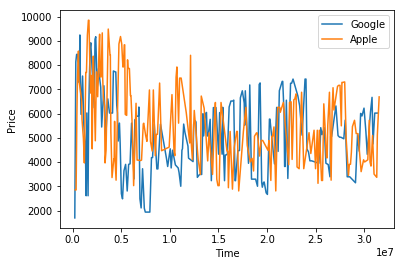

In [7]:
Prices = extract_prices('trace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

## ZITs wich do not ruin themselves

Our ZITs can have both negative cash and negative equity. We will make ZITs that don't go broke by respecting the following principle: an agent does not place an order as long as he has an order left in an order book.

In [8]:
class ZITTrader_v2(Trader):
    def __init__(self, market, initial_assets=None, cash=0):
        Trader.__init__(self, market, initial_assets, cash)
    def __str__(self):
        return "ZITv2 " + super().__str__()
    def decide_order(self, market, asset):
        # We count the number of orders placed in the orderbooks by this agent 
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset2].asks.tree+market.orderbooks[asset2].bids.tree if o.source == self]) for asset2 in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK' and self.assets[asset] > 0: # If we have quantity > 0 of shares for this asset... 
                # You will not sell an amount of stock > to the one you have.
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, min(self.assets[asset], 9)))
            elif direction == 'BID' and self.cash >= 1000: # To buy, you need money...
                price = random.randint(1000, min(self.cash, 9999))
                # We will not place a bid for a volume of assets with a value > to the cash we have.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, min(self.cash//price, 9)))
        return None # In all other cases, we do not place an order 

Note: The way to count the number of orders placed by the agent is clearly not optimized. Each time an order is placed, we do $\Theta(\sum_{a\in Assets}|\text{Orderbook}_a|)$ operations... It would be enough to add a boolean attribute to the `ZITTrader_v3` class which remembers if an order is placed, and which is modified by the `market.match` method as soon as this order is removed from an order book. It's not done here, because it's more complicated to do, and we'll see that these ZITs won't behave satisfactorily, so we won't use them.

We'll check that this ZIT does what we want with simple examples. First, we'll see what happens if we initialize the agents without cash or stock. They shouldn't be placing any orders.

In [9]:
m = Market(['Apple'])
t = ZITTrader_v2(m)
m.add_trader(t)
m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZITv2 13;0;Apple:0
AgentWealth;ZITv2 13;0;402432
Tick;1;486656
# Nb orders received: 0
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 0


Cash-only agents will either send nothing or bid orders.

In [10]:
m = Market(['Apple'])
t = ZITTrader_v2(m, cash=10000)
m.add_trader(t)
for i in range(3):
    m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZITv2 14;10000;Apple:0
AgentWealth;ZITv2 14;10000;302592
Tick;1;355584
Tick;2;371968
Tick;3;384256
# Nb orders received: 0
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 0


Agents with nothing but actions will either send nothing or ask orders.


In [11]:
m = Market(['Apple'])
t = ZITTrader_v2(m, initial_assets=[50])
m.add_trader(t)
for i in range(3):
    m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZITv2 15;0;Apple:50
AgentWealth;ZITv2 15;250000;466176
Tick;1;516864
LimitOrder;Apple;ZITv2 15;ASK;9558;6;542976
Tick;2;560384
Tick;3;571904
# Nb orders received: 1
# Nb fixed prices: 0
# Leaving ask size: 1
# Leaving bid size: 0


Now that we know that our ZIT works the way we want it to, we're going to do a simulation with several agents and several rounds of speech and display the prices.

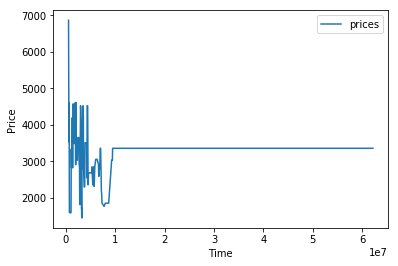

In [12]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file, trace=['price'])
for i in range(100):
    m.add_trader(ZITTrader_v2(m, initial_assets=[50], cash=10000))
for i in range(100):
    m.run_once()
m.print_last_prices()
m.print_state()
file.close()

T, P = extract_prices('trace.dat')['Apple']
plt.plot(T, P, '-',label="prices")
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Very quickly, no more prices are set, as each agent waits for his order to be executed.
You can do a `cat trace.dat | grep -E 'Price;|Tick;' in the console to retrieve only the lines starting with "Tick;" or "Price;" to see when prices were set.

Note: Since "Price;..." lines are only written when a price is set, one is forced to force the market to display the last price of the asset (with `m.print_last_prices()`) at the end of the simulation to see that prices do not change after a certain point in time. (If we didn't do this, we would get the same curve, but truncated: we wouldn't have the stationary part).

## Chartist agent

A chartist agent has two parameters $m < $m. By writing down, $\widehat{p_t}(n)$ the average price $p_{t-n}, \ldots, p_{t-1}$, the agent chooses the order to send as follows:
* If $\widehat{p_t}(m) > \widehat{p_t}(M)$, then the price trend is upward and the agent sends a bid.
* If $\widehat{p_t}(m) < \widehat{p_t}(M)$, then the price trend is downward and the agent sends a ask.
* If $\widehat{p_t}(m) = \widehat{p_t}(M)$, then the agent doesn't send an order.

In [13]:
class Chartist(Trader):
    def __init__(self, market, initial_assets=None, cash=0, m=3, M=5):
        Trader.__init__(self, market, initial_assets, cash)
        self.m = m
        self.M = M
    def __str__(self):
        return "Chartist " + super().__str__()
    def decide_order(self, market, asset):
        def mean_price(n):
            P = market.prices_hist[asset]
            if len(P) >= n:
                s = sum([P[-i] for i in range(n)])
                return s/n
            return None
        mean_m = mean_price(self.m)
        mean_M = mean_price(self.M)
        if mean_m != None and mean_M != None:
            if mean_m > mean_M:
                return LimitOrder(asset, self, 'BID', random.randint(1000, 9999), random.randint(1, 9))
            elif mean_m < mean_M:
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, 9))
        return None

In [14]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file)
for i in range(2):
    m.add_trader(Chartist(m))
for i in range(2):
    m.add_trader(ZITTrader(m))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

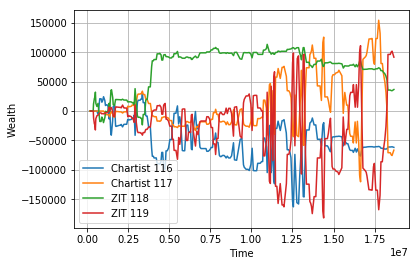

In [15]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

Let's see if a chartist has more wealth on average than a ZIT:

In [16]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file, trace=['wealth', 'price'])
for i in range(90):
    m.add_trader(Chartist(m, m=2, M=5))
for i in range(10):
    m.add_trader(ZITTrader(m))
for i in range(200):
    m.run_once()
m.print_state()
file.close()

In [17]:
Wealths = extract_wealths('trace.dat')
Mean_wealth_chartist = []
Mean_wealth_ZIT = []
for agent in Wealths.keys():
    _, W = Wealths[agent]
    if "Chartist" in agent:
        Mean_wealth_chartist.append(np.mean(np.array(W)))
    else:
        Mean_wealth_ZIT.append(np.mean(np.array(W)))
print("Average wealth of a chartist: %i\nAverage wealth of a ZIT : %i\n" % (np.mean(np.array(Mean_wealth_chartist)), np.mean(np.array(Mean_wealth_ZIT))))

Wealth moyen des chartists : -26431
Wealth moyen des ZIT : 237887



/home/m2mocad/fleurya/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


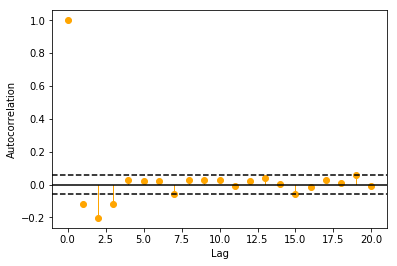

In [18]:
Prices = np.array(extract_prices('trace.dat')['Apple'][1])
Returns = np.log(Prices[1:]) - np.log(Prices[:-1])
acf = stats.acf(Returns, nlags=20)
plt.plot(range(21), acf, 'o', color="orange")
plt.bar([x+0.02 for x in range(21)], acf, .04, color="orange")
plt.axhline(0, color='k')
sigma = max(np.abs(acf[10:]))
plt.axhline(sigma, color='k', linestyle='--')
plt.axhline(-sigma, color='k', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Our chartists look like they're not doing as well as ZITs...

## Automatic agent

We are going to create an agent that will take an order stack as a parameter and that, each time he has the chance to speak, will return the order to the top of the stack.

In [19]:
class Automaton(Trader):
    def __init__(self, market, orders_dict=dict(), initial_assets=None, cash=0, name=None):
        '''orders_dict is a dictionary whose keys are the assets and the values are the lists of the form (direction,price,qty)'''
        Trader.__init__(self, market, initial_assets, cash, name=name)
        self.orders = orders_dict
    def __str__(self):
        return self.name if self.name != None else "Automaton "+ super().__str__()
    def decide_order(self, market, asset):
        if asset not in self.orders.keys() or self.orders[asset] == []:
            return None
        else:
            d, p, q = self.orders[asset].pop(0)
            return LimitOrder(asset, self, d, p, q)

In [20]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file, trace=['wealth'])
# We add an automatic agent that alternately sends a sell order at 6000 and a buy order at 4000 (always with a quantity of 9). 
m.add_trader(Automaton(m, orders_dict={'Apple': [('ASK', 6000, 9), ('BID', 4000, 9)]*50}, name='juliette'))
# Another automatic agent is added which alternately sends a sell order at 4000 and a buy order at 6000 (always with a quantity of 9). 
m.add_trader(Automaton(m, orders_dict={'Apple': [('ASK', 4000, 9), ('BID', 6000, 9)]*50}, name='paul'))
# We add two ZITs
for i in range(2):
    m.add_trader(ZITTrader(m))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

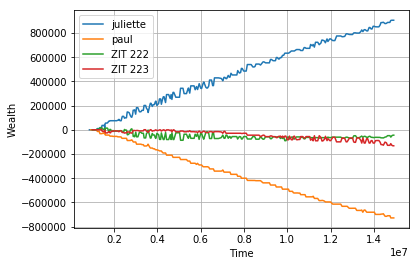

In [21]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

We observe that one of the two automatic agents has an increasing wealth (the one that sells at 6000 and buys at 4000) and that the other has a decreasing wealth (the one that sells at 4000 and buys at 6000).

## Arbitragist agent

In [22]:
class Arbitragist(Trader):
    def __init__(self, market, initial_assets=None, cash=0, period=2):
        Trader.__init__(self, market, initial_assets, cash)
        self.period = max(period, 2)
        self.time = period-1
    def __str__(self):
        return "Arbitragist " + super().__str__()
    def decide_order(self, market, asset):
        self.time += 1
        if self.time == self.period: # passed a certain time period, all our outstanding orders get cancelled 
            self.time = 0
            return CancelMyOrders(asset, self)
        elif self.time == 1: # If we just cancelled our orders, we send our order...
            w = self.get_wealth(market)
            p = market.prices[asset]
            if p != None:
                q = w//(len(market.orderbooks.keys())*p) - self.assets[asset]
                # w//(len(market.orderbooks.keys())*p) represents the quantity of asset shares that the agent should
                # Have if he wanted to distribute all his wealth equally over all the assets
                if q != 0:
                    return LimitOrder(asset, self, 'ASK' if q > 0 else 'BID', p, np.abs(q))
        return None

In [23]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google', 'Microsoft'], out=file)
m.add_trader(ZITTrader(m, [5, 5, 5], cash=100000))
m.add_trader(Chartist(m, [5, 5, 5], cash=100000))
m.add_trader(Arbitragist(m, [5, 5, 5], cash=100000, period=10))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

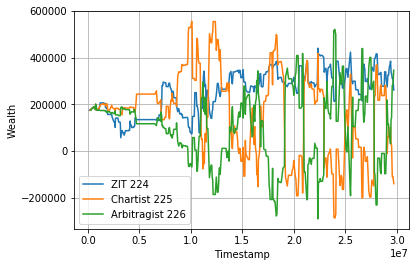

In [24]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Timestamp')
plt.ylabel('Wealth')
plt.show()

We will compare the average wealth of chartists, arbitragists and ZITs:

In [25]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google', 'Microsoft'], out=file, trace=['wealth'])
for i in range(20):
    m.add_trader(ZITTrader(m, [10, 10, 10], cash=10000))
    m.add_trader(Chartist(m, [10, 10, 10], cash=10000, m=2, M=5))
    m.add_trader(Arbitragist(m, [10, 10, 10], cash=10000, period=10))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

In [26]:
Wealths = extract_wealths('trace.dat')
Mean_wealth_arbitragist = []
Mean_wealth_chartist = []
Mean_wealth_ZIT = []
for agent in Wealths.keys():
    _, W = Wealths[agent]
    if "Chartist" in agent:
        Mean_wealth_chartist.append(np.mean(np.array(W)))
    elif "Arbitragist" in agent:
        Mean_wealth_arbitragist.append(np.mean(np.array(W)))
    else:
        Mean_wealth_ZIT.append(np.mean(np.array(W)))
print("Average wealth of arbitragists : %i\nAverage wealth of chartists : %i\nAverage wealth of ZITs : %i\n" % (np.mean(np.array(Mean_wealth_arbitragist)), np.mean(np.array(Mean_wealth_chartist)), np.mean(np.array(Mean_wealth_ZIT))))

Wealth moyen des arbitragists : 113911
Wealth moyen des chartists : 60896
Wealth moyen des ZITs : 323348



## Tracer un faisceau de courbes de prix

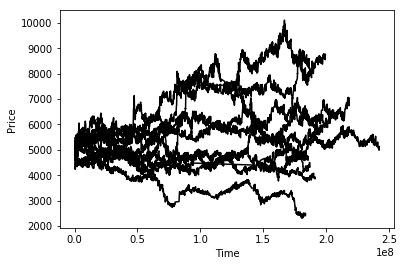

In [27]:
nb_simulations = 10
for i in range(nb_simulations):
    file = open('trace.dat', 'w')
    m = Market(['Apple'], out=file, trace=['price'], fix='S')
    for i in range(10):
        m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    for i in range(500):
        m.run_once()
    file.close()
    Prices = extract_prices('trace.dat')
    plt.plot(Prices['Apple'][0], Prices['Apple'][1], 'k-')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

## Exercises

**1. Create a simulation with only 2 ZIT agents: one with 20% and 30% (respectively Ask and Bid) and
the other one with 40% and 50% (respectively Ask and Bid), over a continuous period of 1000 laps**

In [28]:
# Answer

file = open('mytrace.dat', 'w')
m = Market(['Apple'], out=file)
t1 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.2, pb_bid=0.3)
t2 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.4, pb_bid=0.5)
m.add_trader(t1)
m.add_trader(t2)

ntours = 1000

for i in range(ntours):
    m.run_once()
m.print_state()
file.close()

print(t1.get_infos(m))
print(t2.get_infos(m))

ZIT 387:
Cash: -59235
Apple: 120
Wealth: 9765

ZIT 388:
Cash: 59235
Apple: -120
Wealth: -9765



`extract_limit_orders` returns a dictionary containing for each trader his limit orders history. 

**2. Use this function to check the starting probabilities**.

In [29]:
# Answer

limitorders = extract_limit_orders('mytrace.dat')
counts = {}
for trader in limitorders:
    counts[trader] = {'ASK' : 0, 'BID' : 0}
    for order in limitorders[trader][1]:
        if order == 'ASK':
            counts[trader]['ASK']+=1
        else:
            counts[trader]['BID']+=1

for trader in counts:
    print(trader," : ")
    print('Proportion of ASKs :',100*counts[trader]['ASK']/ntours,'%')
    print('Proportion of BIDs :',100*counts[trader]['BID']/ntours,'%')
    

ZIT 388  : 
Proportion de ASK : 42.6 %
Proportion de BID : 46.1 %
ZIT 387  : 
Proportion de ASK : 20.8 %
Proportion de BID : 27.4 %


**3. Program a ZITalt agent that alternates between BID and ASK orders (not 2 orders of the same direction in a row), with the direction of the first order as an argument to the creation of the agent. He will have a 50% chance to send an order at every round of speech.**

In [30]:
# Answer

class ZITalt(Trader):
    def __init__(self, market, initial_assets=None, cash=0, start='ASK'):
        Trader.__init__(self, market, initial_assets, cash)
        self.next = start
    def __str__(self):
        return "ZITalt %i" % self.trader_id
    def decide_order(self, market, asset):
            if(random.random()>0.5):
                current = self.next
                if self.next=='BID':
                    self.next='ASK'
                else:
                    self.next='BID'
                return LimitOrder(asset, self, current, random.randint(1000,9999), random.randint(1, 9))

            else:
                return None

**4. Start an experiment with 2 ZITalt agents, one starting with an ASK and the other with a BID, over 30 rounds of speech**.

In [31]:
# Answer

file = open('mytrace.dat', 'w')
m = Market(['Apple'], out=file)
task = ZITalt(m,start = 'ASK')
tbid = ZITalt(m,start = 'BID')
m.add_trader(task)
m.add_trader(tbid)
ntours = 30

for i in range(ntours):
    m.run_once()
m.print_state()
file.close()

**5. Check the behavior of the agents by displaying for each one the list of the types of all the orders sent thanks to `extract_limit_orders`**.

In [32]:
# Answer

limitorders = extract_limit_orders('mytrace.dat')
for trader in limitorders:
    print("{}\n{}\n({} ordres)\n".format(trader,limitorders[trader][1],len(limitorders[trader][1])))

ZITalt 389
['ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK']
(19 ordres)

ZITalt 390
['BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID']
(15 ordres)

